# Wav2Rec

---

In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import umap

from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from typing import Optional, List, Tuple

from experiments.fma.data.meta import FmaMetadata

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [16, 6]

**Note**: in order to import `experiments` you must either (a) run this notebook from the root of the repository or (b) set the working directory to the root of the repository.

In [4]:
FMA_METADATA_PATH = Path("fma_metadata").absolute()
PROJECTIONS_PATH = Path('wav2rec_projections.csv').absolute()

## Data

First, let's load some projections. (You can generate a csv file like this one by following [train.ipynb](train.ipynb).)

In [5]:
df = pd.read_csv(PROJECTIONS_PATH)

Let's also go ahead and group the data by "stage" (training data vs validation data).

In [6]:
df_groups = {
    group: frame.drop(["network", "stage"], axis=1)
    for group, frame in df.groupby(["stage"])
}

Finally, we'll load the FMA metadata, which is used recover additional information about the tracks.

In [7]:
fma_metadata = FmaMetadata(FMA_METADATA_PATH)

---

## Visualization

With the data loaded, we can build a few visualizations of the representations to try to get an intuition what the model has learned. <br>
This is complicated by the fact that the projections exist in a 256 dimension space, which is far too much to visualize. <br>
So, below I use the [UMAP](https://umap-learn.readthedocs.io/en/latest/) dimensionality reduction technique to project the data down to 2D.

In [8]:
def frame_projector(
    frame: pd.DataFrame,
    n_components: Optional[int] = 2,
) -> pd.DataFrame:
    """Project a features in ``frame`` to ``n_components`` dimensions.
    
    Args:
        frame (pd.DataFrame): a pandas dataframe with all feature columns,
            with the exception of 'track_id'
        n_components (int): number of components to use.
    
    """
    values = frame.drop("track_id", axis=1).values
    if n_components is None or n_components == values.shape[-1]:
        proj = values
    elif n_components < values.shape[-1]:
        values_scaled = StandardScaler().fit_transform(values)
        proj = umap.UMAP(n_components=n_components).fit_transform(values_scaled)
    else:
        raise ValueError(f"Unable to project from to `n_components`")
    
    return (
        pd.DataFrame(proj)
        .add_prefix('Feature ')
        .assign(
            track_id=frame['track_id'].values,
            top_genre=[fma_metadata.get_track_top_genre(i) for i in frame['track_id']],
            all_genres=[fma_metadata.get_track_genres(i) for i in frame['track_id']],
        )
    )


def visualizer(
    frame: pd.DataFrame, 
    x: str,
    y: str,
    hue: str,
    count_threshold: int = None,
    genres: Optional[List[str]] = None
) -> None:
    if count_threshold:
        value_counts = frame[hue].value_counts()
        sel = frame[hue].isin(value_counts[value_counts > count_threshold].index)
    elif genres:
        sel = frame["top_genre"].isin(genres)
    else:
        sel = pd.Series([True] * len(frame))
    
    plot = sns.scatterplot(
        data=frame[sel], 
        x=x, 
        y=y, 
        hue=hue
    )
    plot.legend(loc='center left', bbox_to_anchor=(1, 0.25));

In [9]:
train_plotframe = frame_projector(df_groups['train'])

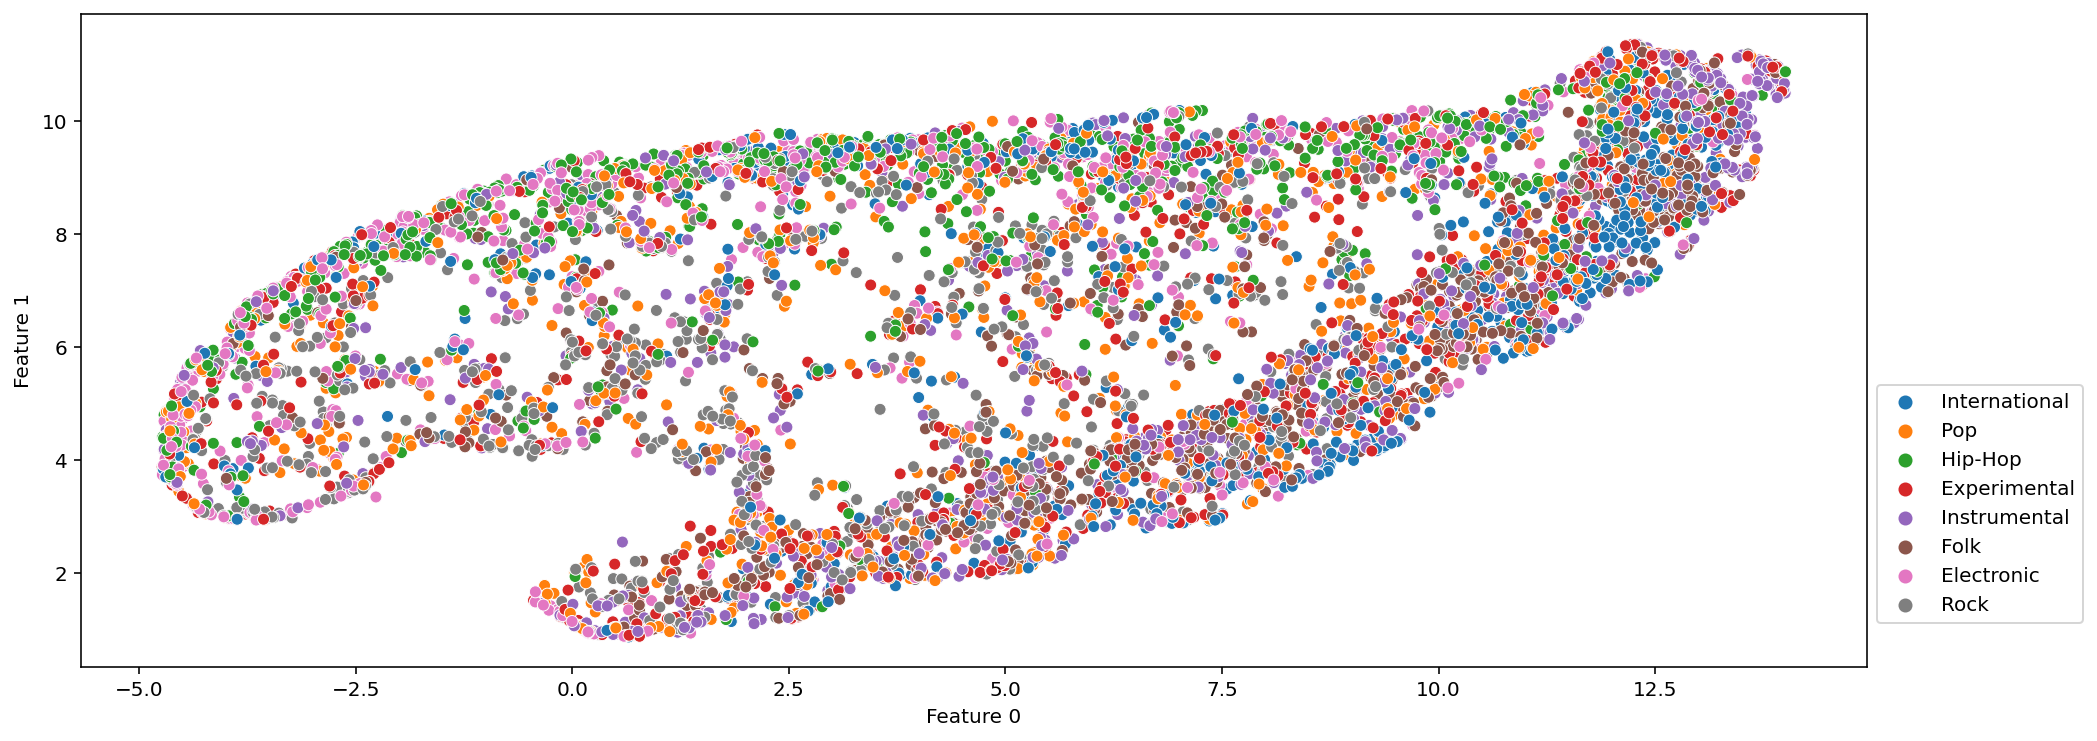

In [10]:
train_plotframe.pipe(
    visualizer,
    x='Feature 0',
    y='Feature 1',
    hue='top_genre',
)

There is a lot going on here! To make things easier, let's focus on two genres that, intuitively at least, should be quite different: Folk and Hip-Hop.

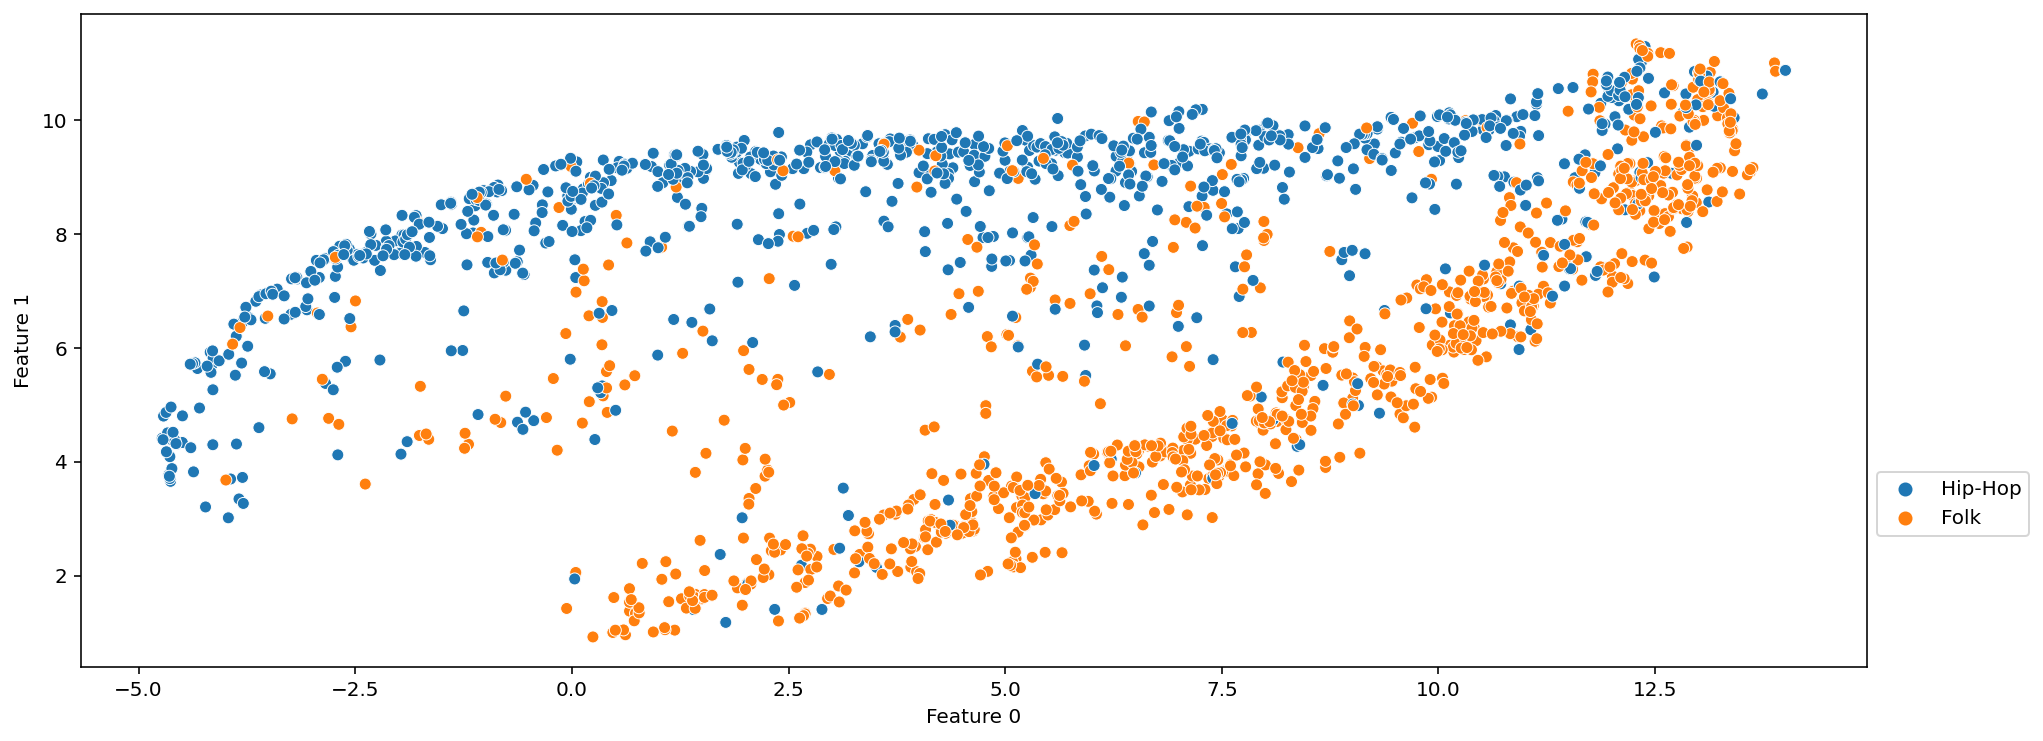

In [11]:
train_plotframe.pipe(
    visualizer,
    x='Feature 0',
    y='Feature 1',
    hue='top_genre',
    genres=["Folk", "Hip-Hop"]
)

Indeed, we can see a reasonably pronounced degree of separation between these two genres.

We can also look at two genres we might expect to be close together / similar: Rock and Pop.

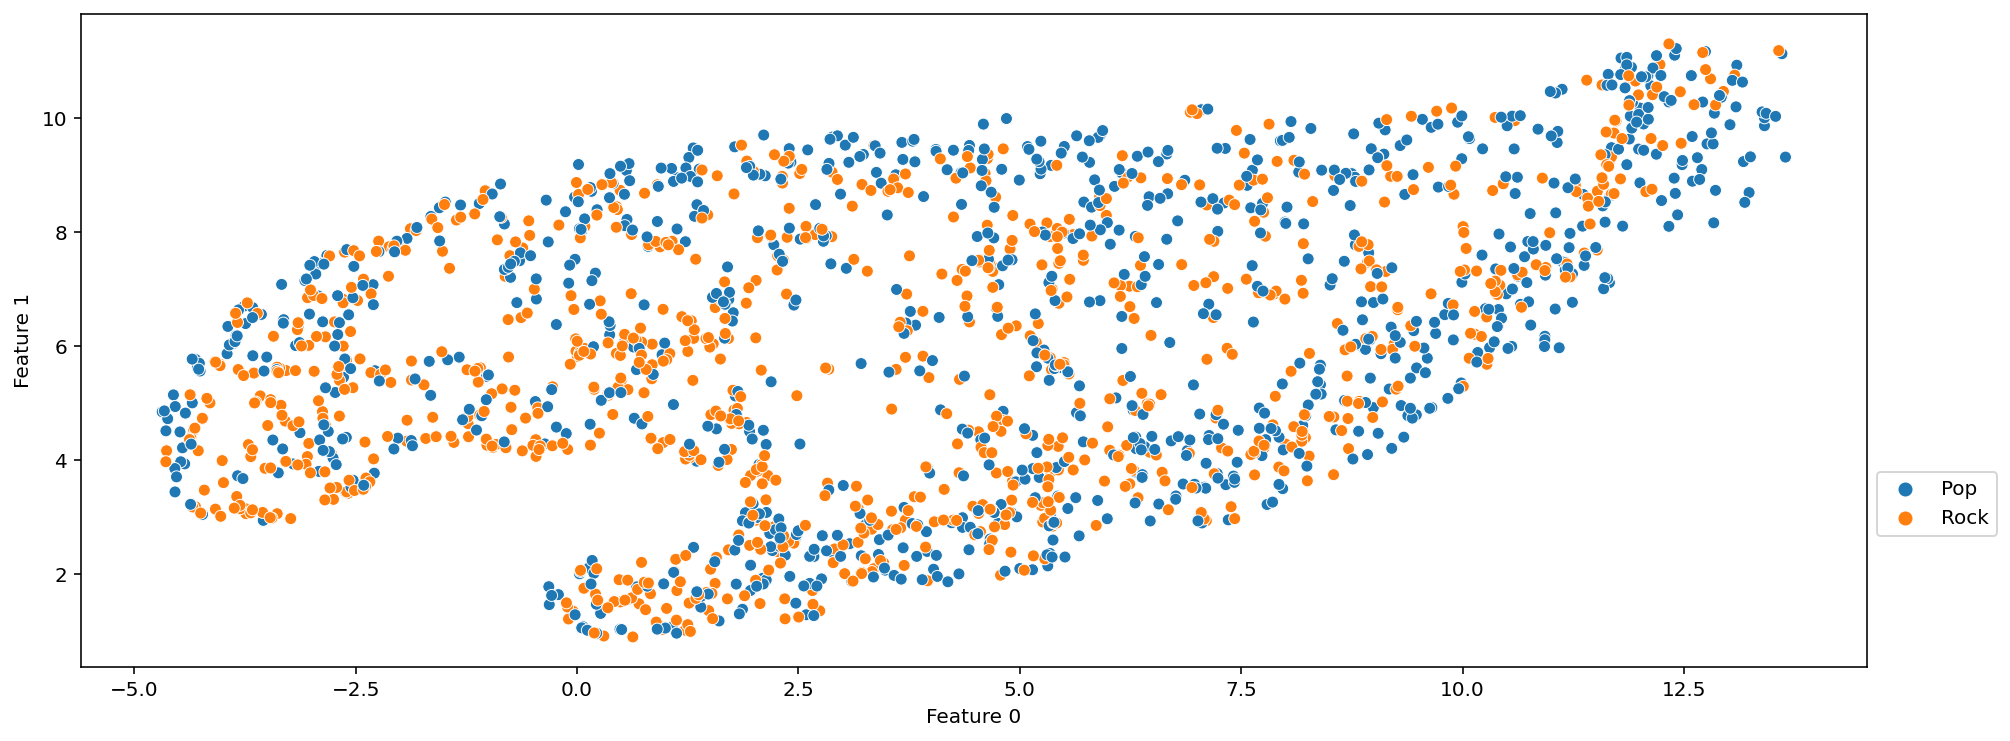

In [12]:
train_plotframe.pipe(
    visualizer,
    x='Feature 0',
    y='Feature 1',
    hue='top_genre',
    genres=["Rock", "Pop"]
)

Here, the points are not clearly separable. So, once again it appears that the representations learned are quite sensible.

---

## Genre Classification


Next, we can use the representations learned by the model for genre classification.

In [13]:
def selector(frame: pd.DataFrame, genres: Optional[List[str]] = None) -> pd.DataFrame:
    if genres:
        return frame[frame["top_genre"].isin(genres)]
    else:
        return frame

In [14]:
def split(train_df: pd.DataFrame, val_df: pd.DataFrame, genres: Optional[List[str]] = None) -> Tuple[pd.DataFrame, ...]:
    # Training Data
    df_train = frame_projector(train_df, n_components=None).pipe(selector, genres=genres)
    x_train = df_train.drop(["track_id", 'top_genre', 'all_genres'], axis=1).values
    y_train = df_train['top_genre'].values
    
    # Validation data
    df_val = frame_projector(val_df, n_components=None).pipe(selector, genres=genres)
    x_val = df_val.drop(["track_id", 'top_genre', 'all_genres'], axis=1).values
    y_val = df_val['top_genre'].values
    
    return x_train, x_val, y_train, y_val

### All

In [15]:
x_train, x_val, y_train, y_val = split(
    train_df=df_groups['train'],
    val_df=df_groups['val'],
)

In [16]:
clf_all_rf = RandomForestClassifier().fit(x_train, y_train)

In [17]:
accuracy_score(y_val, clf_all_rf.predict(x_val))

0.35

In [18]:
f1_score(y_val, clf_all_rf.predict(x_val), average='weighted')

0.3397529098885775

### Folk & Hip-Hop

In [19]:
x_train, x_val, y_train, y_val = split(
    train_df=df_groups['train'],
    val_df=df_groups['val'],
    genres=["Folk", "Hip-Hop"],
)
clf_folk_hip_hop_rf = RandomForestClassifier().fit(x_train, y_train)

In [20]:
accuracy_score(y_val, clf_folk_hip_hop_rf.predict(x_val))

0.8484848484848485

In [21]:
f1_score(y_val, clf_folk_hip_hop_rf.predict(x_val), pos_label="Folk")

0.8421052631578948

### Rock & Pop

In [22]:
x_train, x_val, y_train, y_val = split(
    train_df=df_groups['train'],
    val_df=df_groups['val'],
    genres=["Rock", "Pop"],
)
clf_rock_pop_rf = RandomForestClassifier().fit(x_train, y_train)

In [23]:
accuracy_score(y_val, clf_rock_pop_rf.predict(x_val))

0.7613636363636364

In [24]:
f1_score(y_val, clf_rock_pop_rf.predict(x_val), pos_label="Rock")

0.7741935483870968

## Notes

It's import to point out that there is a lot of additional work that could be done to improve the metrics obtained here.
Namely, exploring other algorithms, hyperparameter tuning, more extensive model evaluation, comparisons to the simplest possible models, etc. This section is simply meant as a brief demonstration of what's possible, so feel
free to dive in on your own.

Nevertheless, the results obtained here are quite promising and, by and large, appear to accord with what one would expect
given the visualizations above. 

  * The performance of the 'all' model was modest. Part of this is surely due to the fact it's difficult to assign many pieces of music to a single category. 
  * The 'Folk & Hip-Hop' model performed very well. Of course, this is a much simpler problem than the 'all' model is tasked with solving.
  * The 'Rock & Pop' did not perform as well as the 'Folk & Hip-Hop' model, but the difference was much smaller than the visualization above would suggest. In this case, it's  worth keeping in mind that the visualization above is a 2D projection of the features the model 'sees'. (That is, a lot of information in the underlying projections is simply not conserved in the plot above.)